In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from catboost import CatBoostRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [51]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

list_directory_tree_with_os_walk('.')

import pandas as pd
import matplotlib.pyplot as plt

# Load your data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

print(X_test_estimated_a.dtypes)


Directory: .
  File: .DS_Store
  File: catBoost.ipynb
  File: experiment_A
  File: experiment_B
  File: experiment_C
  File: feature_selection_report.txt
  File: final_model_for_location_A.pkl
  File: final_model_for_location_B.pkl
  File: final_model_for_location_C.pkl
  File: Location_A_comparisons.png
  File: Location_B_comparisons.png
  File: Location_C_comparisons.png
  File: logs.log
  File: my_first_submission.csv
  File: predictions_run13.csv
  File: predictions_run14.csv
  File: predictions_run16.csv
  File: predictions_run17.csv
  File: predictions_run18.csv
  File: pyCarat.ipynb
  File: Readme.md
  File: read_files.ipynb
  File: run_counter.txt
  File: sample_submission.csv
  File: test.csv
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet

In [52]:
import pandas as pd

# Function to calculate forecast duration
def calculate_forecast_duration(df, observed=True):
    if observed:
        df['forecast_duration'] = 0  # set to zero for observed data
    else:
        df['forecast_duration'] = (df['date_forecast'] - df['date_calc']).dt.total_seconds() / 3600  # calculate for estimated data
    return df

# Apply the function to your DataFrames
X_train_observed_a = calculate_forecast_duration(pd.read_parquet('A/X_train_observed.parquet'), observed=True)
X_train_observed_b = calculate_forecast_duration(pd.read_parquet('B/X_train_observed.parquet'), observed=True)
X_train_observed_c = calculate_forecast_duration(pd.read_parquet('C/X_train_observed.parquet'), observed=True)

X_train_estimated_a = calculate_forecast_duration(pd.read_parquet('A/X_train_estimated.parquet'), observed=False)
X_train_estimated_b = calculate_forecast_duration(pd.read_parquet('B/X_train_estimated.parquet'), observed=False)
X_train_estimated_c = calculate_forecast_duration(pd.read_parquet('C/X_train_estimated.parquet'), observed=False)

X_test_estimated_a = calculate_forecast_duration(pd.read_parquet('A/X_test_estimated.parquet'), observed=False)
X_test_estimated_b = calculate_forecast_duration(pd.read_parquet('B/X_test_estimated.parquet'), observed=False)
X_test_estimated_c = calculate_forecast_duration(pd.read_parquet('C/X_test_estimated.parquet'), observed=False)

# After this, you can concatenate or otherwise combine your data as needed for modeling


In [53]:
X_train_a = pd.concat([X_train_observed_a, X_train_estimated_a])
X_train_b = pd.concat([X_train_observed_b, X_train_estimated_b])
X_train_c = pd.concat([X_train_observed_c, X_train_estimated_c])

In [54]:
merged_data_a = pd.merge(X_train_a, train_a,how='inner', left_on='date_forecast', right_on='time')
merged_data_b = pd.merge(X_train_b, train_b,how='inner', left_on='date_forecast', right_on='time')
merged_data_c = pd.merge(X_train_c, train_c,how='inner', left_on='date_forecast', right_on='time')



In [55]:
a = merged_data_a.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
b = merged_data_b.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
c = merged_data_c.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()



'''a = a.drop(columns=['time'])
b = b.drop(columns=['time'])
c = c.drop(columns=['time'])'''

y = a['pv_measurement']
X = a.drop(columns=['pv_measurement'])#, 'date_forecast', 'date_calc', 'time'])

y_b = b['pv_measurement']
X_b = b.drop(columns=['pv_measurement'])#, 'date_forecast', 'date_calc','time'])

y_c = c['pv_measurement']
X_c = c.drop(columns=['pv_measurement'])#, 'date_forecast', 'date_calc','time'])
print()

X_test_a = X_test_estimated_a.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
X_test_b = X_test_estimated_b.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
X_test_c = X_test_estimated_c.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()

def drop_missing_values(X, y):
    # Find indices where 'y' has missing data
    missing_indices = y[y.isna()].index

    # Drop these from 'y'
    y_dropped = y.drop(missing_indices)

    # Also drop these from 'X'
    # Assuming 'X' has the same index as 'y', this will drop the corresponding rows
    X_dropped = X.drop(missing_indices)

    return X_dropped, y_dropped

# For each of your datasets:
X, y = drop_missing_values(X, y)
X_b, y_b = drop_missing_values(X_b, y_b)
X_c, y_c = drop_missing_values(X_c, y_c)
print(X.dtypes)



date_forecast                     datetime64[ns]
absolute_humidity_2m:gm3                 float32
air_density_2m:kgm3                      float32
ceiling_height_agl:m                     float32
clear_sky_energy_1h:J                    float32
clear_sky_rad:W                          float32
cloud_base_agl:m                         float32
dew_or_rime:idx                          float32
dew_point_2m:K                           float32
diffuse_rad:W                            float32
diffuse_rad_1h:J                         float32
direct_rad:W                             float32
direct_rad_1h:J                          float32
effective_cloud_cover:p                  float32
elevation:m                              float32
fresh_snow_12h:cm                        float32
fresh_snow_1h:cm                         float32
fresh_snow_24h:cm                        float32
fresh_snow_3h:cm                         float32
fresh_snow_6h:cm                         float32
is_day:idx         

In [56]:
'''# init server
!mlflow ui
import mlflow 
mlflow.set_tracking_uri('https://my-tracking-server:5000')'''

"# init server\n!mlflow ui\nimport mlflow \nmlflow.set_tracking_uri('https://my-tracking-server:5000')"

In [57]:
from pycaret.regression import *
from pycaret.regression import setup
#from pycaret.time_series import *

def process_location(X, y, location_name):
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y

    # Setup the environment in PyCaret
    exp_reg = setup(data=data,
                    target='target',
                    session_id=123,
                    date_features= ['date_forecast'],
                    categorical_features =['dew_or_rime:idx','is_day:idx', 'is_in_shadow:idx' ],
                    #remove_outliers=True,
                    #low_variance_threshold =0.05, 
                    html=False,
                    log_experiment=False, 
                    data_split_shuffle= False,
                    experiment_name=f'exp_{location_name}')
    
    
    
    

    # Compare models to select the best one
    best_model = compare_models(exclude=['ransac'])  # excluding certain models that may not be suitable

    # Create an ensemble model based on the best performing one
    create_ensemble_model = ensemble_model(best_model, method='Boosting')  # using 'Boosting' as an ensemble method

    # Tune this ensemble model for better performance
    #tuned_ensemble = tune_model(create_ensemble_model)
    #lightgbm = create_model('lightgbm')
    #best_model =compare_models(include = [ 'lightgbm'])
    # Tune the LightGBM model for better performance
    tuned_lightgbm = tune_model(create_ensemble_model, choose_better = True)

    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging', choose_better = True)
    # Finalize the model - this will train it on the complete dataset
    final_model = finalize_model(bagged_lightgbm)
    # Finalize the model - this will train it on the complete dataset
    #final_model = finalize_model(tuned_ensemble)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
    #plot_model(final_model)
    #save_experiment(f'experiment_{location_name}')
    return final_model

# Assuming X, y, X_b, y_b, X_c, y_c are your features and targets for locations A, B, C after dropping missing values
model_a = process_location(X, y, 'A')
model_b = process_location(X_b, y_b, 'B')
model_c = process_location(X_c, y_c, 'C')


                    Description        Value
0                    Session id          123
1                        Target       target
2                   Target type   Regression
3           Original data shape  (34061, 48)
4        Transformed data shape  (34061, 52)
5   Transformed train set shape  (23842, 52)
6    Transformed test set shape  (10219, 52)
7              Ordinal features            2
8              Numeric features           43
9                 Date features            1
10         Categorical features            3
11     Rows with missing values        97.6%
12                   Preprocess         True
13              Imputation type       simple
14           Numeric imputation         mean
15       Categorical imputation         mode
16     Maximum one-hot encoding           25
17              Encoding method         None
18               Fold Generator        KFold
19                  Fold Number           10
20                     CPU Jobs           -1
21        

                                    Model         MAE           MSE  \
lightgbm  Light Gradient Boosting Machine    213.8854  2.224300e+05   
catboost               CatBoost Regressor    220.6304  2.208500e+05   
gbr           Gradient Boosting Regressor    223.6382  2.191656e+05   
rf                Random Forest Regressor    213.5028  2.241593e+05   
et                  Extra Trees Regressor    213.2473  2.189867e+05   
en                            Elastic Net    251.1592  2.369179e+05   
huber                     Huber Regressor    274.0078  3.352414e+05   
omp           Orthogonal Matching Pursuit    294.5485  3.233889e+05   
llar         Lasso Least Angle Regression    257.6713  2.369455e+05   
lasso                    Lasso Regression    257.6788  2.369312e+05   
br                         Bayesian Ridge    258.6467  2.371101e+05   
lr                      Linear Regression    262.5346  2.377645e+05   
ridge                    Ridge Regression    261.8310  2.375050e+05   
ada   

           MAE          MSE      RMSE      R2   RMSLE     MAPE
Fold                                                          
0     373.9362  449550.4997  670.4853  0.7582  1.4223   1.7503
1     143.6659  103117.7671  321.1196  0.8317  2.0943   5.6677
2     117.2089   92504.6778  304.1458  0.7199  1.8055   7.0850
3     341.3196  358264.1792  598.5517  0.8332  1.0936   1.2917
4     312.5214  331430.7136  575.7002  0.7967  1.3566   1.4860
5      80.6000   37128.0982  192.6865  0.7460  2.2983   9.6698
6     196.2015  179586.4728  423.7764  0.8103  1.5447   2.5709
7     398.7019  448333.6799  669.5772  0.8302  1.0465   1.9005
8     228.0585  212020.1765  460.4565  0.7906  1.5718   1.6628
9      53.5099   18245.9959  135.0777  0.0366  2.2165  10.7187
Mean  224.5724  223018.2261  435.1577  0.7153  1.6450   4.3803
Std   119.5307  155573.9845  183.4557  0.2292  0.4233   3.4463


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     356.0837  434002.4129  658.7886  0.7666  1.1798  1.4548
1     124.7575   96594.9298  310.7972  0.8423  1.2758  2.5586
2     108.1832   96058.0635  309.9324  0.7091  1.3188  4.8605
3     320.7242  338339.8612  581.6699  0.8425  0.8462  0.9020
4     300.5591  326314.7000  571.2396  0.7999  0.9329  1.0863
5      62.1535   33233.6355  182.3009  0.7726  1.6633  4.3711
6     181.8569  167212.2482  408.9159  0.8234  1.1322  1.7987
7     373.5870  417827.1825  646.3955  0.8417  0.8245  1.5293
8     202.5879  195253.3524  441.8748  0.8072  1.1013  1.2117
9      37.4262   11863.2184  108.9184  0.3736  1.5907  6.7079
Mean  206.7919  211669.9604  422.0833  0.7579  1.1865  2.6481
Std   117.7197  148908.6372  183.0727  0.1342  0.2716  1.8789


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test = pd.read_csv('test.csv')
test

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

# Example, let the predictions be random values
test['prediction'] = np.random.rand(len(test))
print(test)
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)


        id                 time  prediction location
0        0  2023-05-01 00:00:00    0.696469        A
1        1  2023-05-01 01:00:00    0.286139        A
2        2  2023-05-01 02:00:00    0.226851        A
3        3  2023-05-01 03:00:00    0.551315        A
4        4  2023-05-01 04:00:00    0.719469        A
...    ...                  ...         ...      ...
2155  2155  2023-07-03 19:00:00    0.635484        C
2156  2156  2023-07-03 20:00:00    0.798985        C
2157  2157  2023-07-03 21:00:00    0.783102        C
2158  2158  2023-07-03 22:00:00    0.421518        C
2159  2159  2023-07-03 23:00:00    0.301484        C

[2160 rows x 4 columns]


Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warn

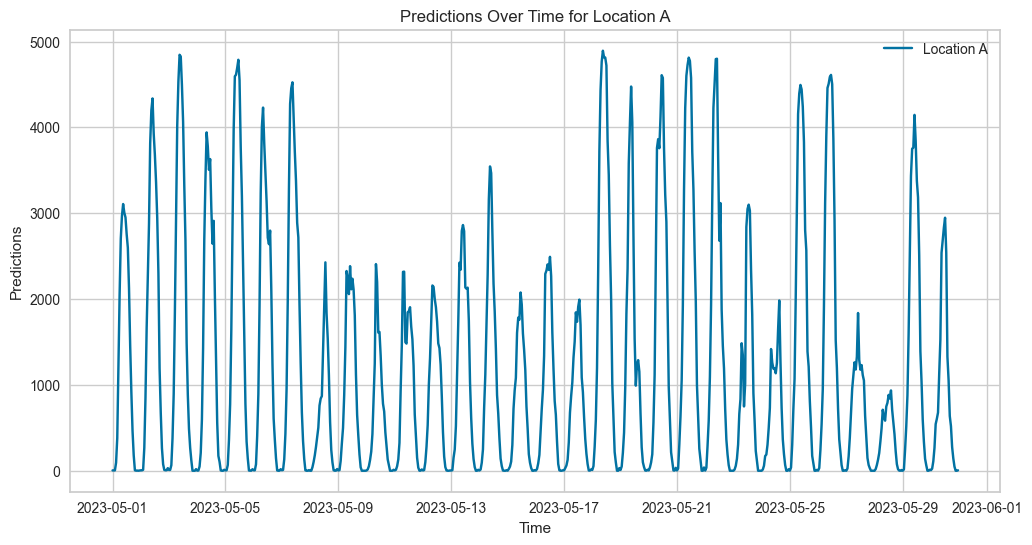

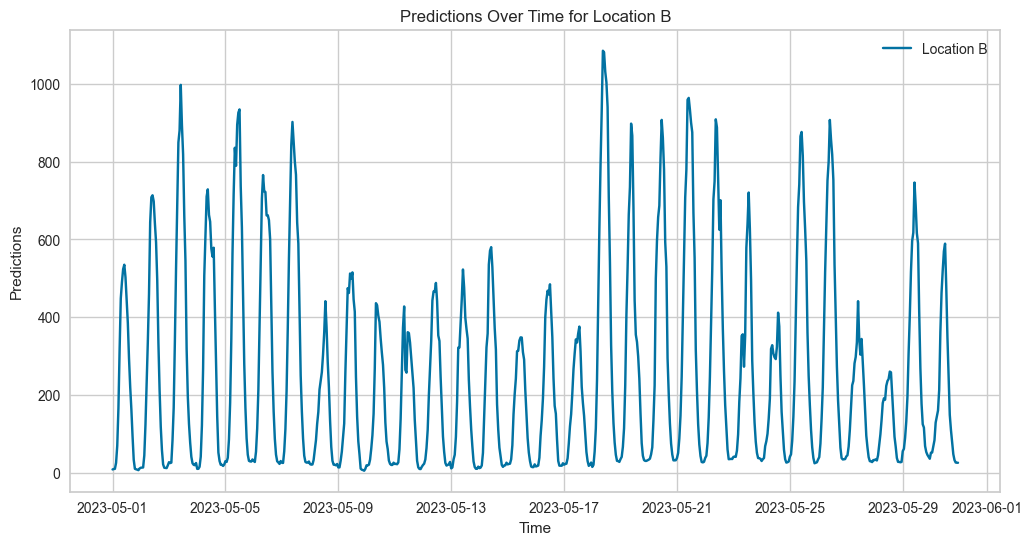

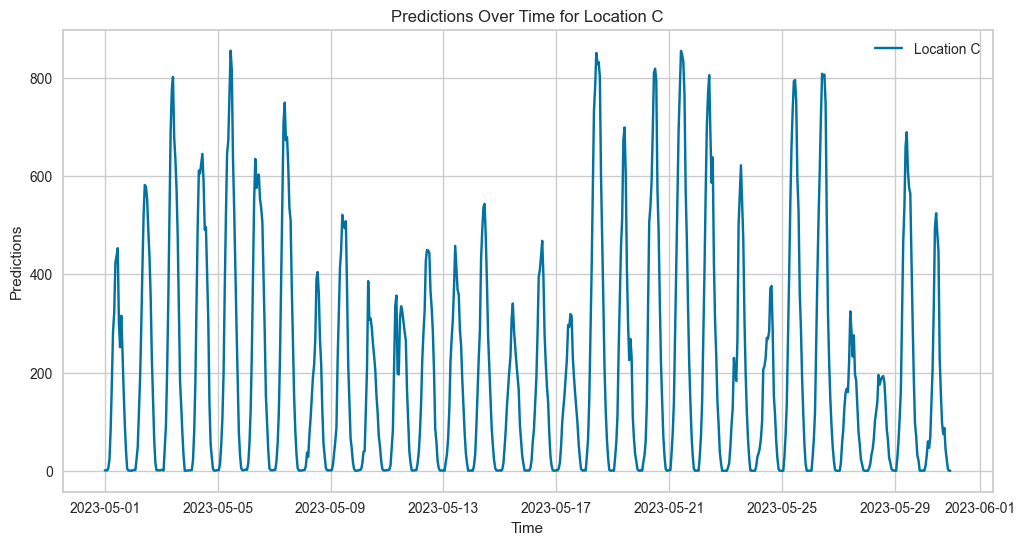

In [ ]:
# Convert predictions to numpy arrays for reshaping
from pycaret.regression import load_model, predict_model
import pandas as pd

# Load the saved models
final_model_a = load_model('final_model_for_location_A')
final_model_b = load_model('final_model_for_location_B')
final_model_c = load_model('final_model_for_location_C')


'''def make_predictions(location_name, new_data, data):
    # Load the saved experiment
    loaded_experiment = load_experiment(f'experiment_{location_name}', data=data)
    
    # Make predictions on new data
    predictions = predict_model(loaded_experiment, data=new_data)
    
    return predictions
# Assuming X_test_a, X_test_b, and X_test_c are your test datasets for locations A, B, and C
# Predict on new data
# For location A
combined_data_a = X.copy()
combined_data_a['target'] = y

# For location B
combined_data_b = X_b.copy()
combined_data_b['target'] = y_b

# For location C
combined_data_c = X_c.copy()
combined_data_c['target'] = y_c

predictions_a = make_predictions('A', X_test_estimated_a, combined_data_a)
predictions_b = make_predictions('B', X_test_estimated_b,combined_data_b)
predictions_c = make_predictions('C', X_test_estimated_c, combined_data_c)'''
predictions_a = predict_model(final_model_a, data=pd.DataFrame(X_test_a))
predictions_b = predict_model(final_model_b, data=pd.DataFrame(X_test_b))
predictions_c = predict_model(final_model_c, data=pd.DataFrame(X_test_c))

print(predictions_a.head())
# The predictions are in the 'Label' column of the returned DataFrame
predicted_values_a = predictions_a['prediction_label']
predicted_values_b = predictions_b['prediction_label']
predicted_values_c = predictions_c['prediction_label']

cat_prediction_a_np = predicted_values_a.values.astype(float)
cat_prediction_b_np = predicted_values_b.values.astype(float)
cat_prediction_c_np = predicted_values_c.values.astype(float)

hourly_prediction_a_np = np.clip(cat_prediction_a_np, 0, None)
hourly_prediction_b_np = np.clip(cat_prediction_b_np, 0, None)
hourly_prediction_c_np = np.clip(cat_prediction_c_np, 0, None)

num_predictions = len(hourly_prediction_a_np)
print(len(hourly_prediction_a_np))
timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

# Step 1: Create individual DataFrames for each location
df_a = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_a_np,
    'location': 'A'
})

df_b = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_b_np,
    'location': 'B'
})

df_c = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_c_np,
    'location': 'C'
})

# Step 2: Concatenate these DataFrames
final_df = pd.concat([df_a, df_b, df_c], ignore_index=True)

# Step 3: Reset the index to get the 'id' column
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'id'}, inplace=True)
print(final_df.dtypes)
# Now final_df is in the desired format
#print(final_df)
# Convert 'time' column to datetime if it's not already
final_df['time'] = pd.to_datetime(final_df['time'])

# Sort values by time for proper visualization
final_df.sort_values('time', inplace=True)

locations = final_df['location'].unique()

for loc in locations:
    # Filter data for each location
    temp_df = final_df[final_df['location'] == loc]
    
    plt.figure(figsize=(12, 6))  # Create a new figure for each location
    
    # Plotting
    plt.plot(temp_df['time'], temp_df['prediction'], label=f'Location {loc}')
    
    plt.xlabel('Time')
    plt.ylabel('Predictions')
    plt.title(f'Predictions Over Time for Location {loc}')
    plt.legend()
    plt.show()
# Now final_df is in the desired format
#print(final_df)
#print(final_df.columns)
final_df_save = final_df
#print(final_df.columns)
final_df= final_df.drop(columns=['time', 'location'])

#print(final_df)
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)